In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import time

# Problem 1
## Dataset Generation

Write a function to **generate a training set** of size $m$
- randomly generate a weight vector $w \in \mathbb{R}^{10}$, normalize length
- generate a training set $\{(x_i , y_i)\}$ of size m
  - $x_i$: random vector in $\mathbb{R}^{10}$ from $\textbf{N}(0, 1)$
  - $y_i$: $\{0, +1\}$ with $P[y = +1] = \sigma(w \cdot x_i)$ and $P[y = 0] = 1 - \sigma(w \cdot x_i)$

In [2]:
import random
from random import seed
import math

In [3]:
def generate_data(m): # returns the true w as well as X, Y data
    y=[]
    #seed(1)
    X = [[random.gauss(0, 1) for _ in range(10)] for _ in range(m)] # element of X: 10d, size of X: m
    
    #seed(7)
    w = [random.gauss(0, 1) for _ in range(10)]
    w = [i/np.linalg.norm(w) for i in w] # normalize w
    
    
    P = [1 / (1 + math.exp(-np.dot(w, x))) for x in X] # probability of being +1 by standard logistic function
    
    #seed(11)
    y_list = [0, 1]
    for p in P:
        y.append(random.choices(y_list, [1-p,p], k=1)) # randomly select 0 or +1 by the probabilities, return a list
    y = [int(y_i) for y_i in np.array(y)]
    
    return [X,y,w]
    

In [4]:
M = [50,100,150,200,250]

In [5]:
generate_data(1) # test

[[[-0.8408470696213624,
   -0.23348901064713165,
   -0.7229082116023909,
   0.43119938737532526,
   0.21934791483643873,
   -0.7097191937918405,
   1.1246802561509455,
   0.1376678693069359,
   0.9395325161086543,
   -0.04326707423885803]],
 [0],
 [-0.09704053628549374,
  -0.26617088422903185,
  -0.0661093213128441,
  -0.4333608999639601,
  -0.6887314286342145,
  -0.06567824209653268,
  -0.39130257948308916,
  0.12027590955605227,
  -0.1648388888887341,
  -0.23268779089371358]]

## Algorithm 1: logistic regression

The goal is to learn $w$.  Algorithm 1 is logistic
  regression (you may use the built-in method LogisticRegression for this. Use max_iter=1000).

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
def w_diff(m):
    w_diff = []
    for _ in range(10): # repeat 10 times
        X = generate_data(m)[0]
        y = generate_data(m)[1]
        w = generate_data(m)[2]
        logreg = LogisticRegression(solver='liblinear', max_iter=1000)
        logreg.fit(X, y)
        w_diff.append(np.linalg.norm(w-logreg.coef_)) # ∥w − w′∥
    return np.mean(w_diff)  

In [8]:
T = [] # record time

In [9]:
start1 = time.time()

In [10]:
logreg_ans = [w_diff(m_i) for m_i in M] 
logreg_ans

[1.4447408175332899,
 1.2960217752013858,
 1.0356826304136395,
 1.0667677351834173,
 1.05209069504623]

In [11]:
end1 = time.time()
T.append(end1 - start1)
print(end1 - start1)

0.5768938064575195


## Algorithm 2: gradient descent with square loss

Define square loss as
$$L_i(w^{(t)}) = \frac{1}{2} \left( \sigma(w^{(t)} \cdot x) - y_i \right)^2$$

  Algorithm 2 is
  gradient descent with respect to square loss (code this
  up yourself -- run for 1000 iterations, use step size eta = 0.01).

The logistic sigmoid function: $$ \sigma(w^{(t)} \cdot x)  = \frac {1}{(1 + e^{-w^{t} \cdot x)}} $$ 

In [12]:
def sigmoid(z): # z = w′ · x
    return 1 / (1 + np.exp(-1 * z)) # σ(w′ · x)

The loss function (square loss): $$ L_i(w) = \frac{1}{2} \left( \sigma(w^{t} \cdot x) - y \right)^2$$

In [13]:
def loss(predicted, target): # predicted = σ(w′ · x), target = y
    return 0.5*(np.power(predicted - target, 2))  #1/2(σ(w′ · x) − y)2

We want the grandient of the loss function: $$\nabla_w \frac{1}{2} \left( \sigma(w^{t} \cdot x) - y \right)^2 $$ <br>
Let $ z=w^{t} \cdot x $, &emsp; $ r= ( \sigma(w^{t} \cdot x) - y) $, &emsp; we have <br>
$$ \nabla_w L_i(w) = \nabla_w \frac{1}{2} \left( \sigma(w^{t} \cdot x) - y \right)^2 = \frac{\partial L_i}{\partial w} = \frac{\partial L_i}{\partial r} * \frac{\partial r}{\partial z} * \frac{\partial z}{\partial w} $$

Note: dot product of $\sigma(w^{t} \cdot x)$ is a scalar<br>
https://stackoverflow.com/questions/30898562/which-number-represents-rows-and-columns-in-the-tuple-returned-by-shape

Calculate each derivative:

$$ \frac{\partial L_i}{\partial w} =  \sigma(w^{t} \cdot x) - y $$

In [14]:
def loss_deriv(predicted, target):
    return predicted - target # σ(w′ · x) − y

$$ \frac{\partial r}{\partial z} = \sigma(w^{t} \cdot x)*(1-\sigma(w^{t} \cdot x)) $$

In [15]:
def loss_deriv_1(predicted):
    return predicted * (1.0 - predicted) # σ(w′ · x) * (1 - σ(w′ · x))

$$ \frac{\partial z}{\partial w} =  x^{t} $$ <br>
Since the transpose of a 1d array is still a 1d array (i.e. the same array), $ x^{t} = x $

In [16]:
def loss_deriv_2(x):
    return np.array(x) # x

By the chain rule, <br>
$$ \frac{\partial L_i}{\partial w} = \frac{\partial L_i}{\partial r} * \frac{\partial r}{\partial z} * \frac{\partial z}{\partial w} = (\sigma(w^{t} \cdot x) - y)*\sigma(w^{t} \cdot x)*(1-\sigma(w^{t} \cdot x))*x $$ 

Core function to output $ \nabla L_i(w) $  at one iteration with respect to one labeled sample $ (x^{i}, y^{i}) $:

In [17]:
def grad(w_i, x_i, y_i): 
    # Forward
    z = np.dot(w_i, x_i)
    #print("z: ", z)

    predicted = sigmoid(z)
    #print("predicted: ", predicted)
    #print("target: ", y)

    err = loss(predicted, y_i)
    #print("error by the loss function: ", err)

    # Backward 
    g1 = loss_deriv(predicted, y_i)
    g2 = loss_deriv_1(predicted)
    g3 = loss_deriv_2(x_i)
    
    grad = g3 * g2 * g1
    #print("grandient: ", grad)

    return grad

Update w at the end of each iteration: $ w = w- \nabla_w L_i(w) $

In [18]:
def update_w(w, w_grad, learning_rate): # update w
    return w - learning_rate * w_grad

learning_rate = 0.015

### Gradient Descent <br>
the loss function of which averaged over all the points in the training set, and our goal is to find a $w$ which minimizes the MSE: <br>
$$ MSE(w) = \frac{1}{m} \sum_{i=1}^{m} L_i(w) = \frac{1}{m} \sum_{i=1}^{m} \frac{1}{2} \left( \sigma(w^{t} \cdot x^{i}) - y^{i} \right)^2$$

so <br>
$$\nabla_w MSE(w) = \frac{1}{m} \sum_{i=1}^{m} \nabla_w L_i(w) $$

iterations to update $w$ with respect to all the samples $ (x^{1}, y^{1}), ..., (x^{m}, y^{m}) $:

In [19]:
def gradient_descent(w,X,y): # need to input an initial w
    for _ in range(2000): # of update w
        #print ('now w is:', w)
        
        w_i = []
        for x_i,y_i in zip(X,y): 
            w_i.append(grad(w, x_i, y_i))
        w_grad = np.mean(w_i, axis=0)    # average over all the points
        w = update_w(w, w_grad, learning_rate)
        
    #print ('predicted w:', w)
    return w

investigate $∥w − w′∥$:

In [20]:
def w_diff2(m):  # m of samples
    #w0 = np.random.rand(10)
    w0 = np.zeros(10) # initialize w
    
    w_diff2 = []
    for _ in range(1): # repeat 10 times
        X = generate_data(m)[0]
        y = generate_data(m)[1]
        w = generate_data(m)[2]
        #print ('real w:', w)
       
        w_diff2.append(np.linalg.norm(w-gradient_descent(w0,X,y))) # ∥w − w′∥
 
    return np.mean(w_diff2)


In [21]:
start2 = time.time()

In [22]:
GD_ans = [w_diff2(m_i) for m_i in M] # M = [50,100,150,200,250]
GD_ans

[1.491301198627394,
 1.0949527082060033,
 0.8876048109503731,
 1.0744961605020709,
 1.0214553796193349]

In [23]:
end2 = time.time()
T.append(end2 - start2)
print(end2 - start2)

40.08903098106384


## Algorithm 3: stochastic gradient descent with square loss
Similar to gradient descent, except we use the gradient at a single random training point every iteration.

In [24]:
def SGD(w,X,y): # need to input an initial w
    for _ in range(2000): # of updates
        x_i, y_i = random.choices(list(zip(X, y)))[0] # randomly pick one sample with replacement
        w_grad = grad(w, x_i, y_i)

        w = update_w(w, w_grad, learning_rate)
    return w

In [25]:
def w_diff3(m):  # m of samples
    w0 = np.zeros(10) # initialize w
    
    w_diff3 = []
    for _ in range(10): # repeat 10 times
        X = generate_data(m)[0]
        y = generate_data(m)[1]
        w = generate_data(m)[2]
       
        w_diff3.append(np.linalg.norm(w-SGD(w0,X,y))) # ∥w − w′∥
 
    return np.mean(w_diff3)

In [26]:
start3 = time.time()

In [27]:
SGD_ans = [w_diff3(m_i) for m_i in M] # M = [50,100,150,200,250]
SGD_ans

[1.3321412381571984,
 1.1746529283685774,
 1.0488607863662032,
 1.1164874979663049,
 1.1022937402332578]

In [28]:
end3 = time.time()
T.append(end3 - start3)
print(end3 - start3)

6.202341079711914


## Evaluation

Measure error $\|w - \hat{w}\|_2$ for each method at different sample size. For any
  fixed value of $m$, choose many different $w$'s and average the
  values $\|w - 
  \hat{w}\|_2$ for Algorithms 1, 2 and 3.  Plot the results
  for for each algorithm as you make $m$ large (use $m=50, 100, 150, 200, 250$).
  Also record, for each algorithm, the time taken to run the overall experiment.

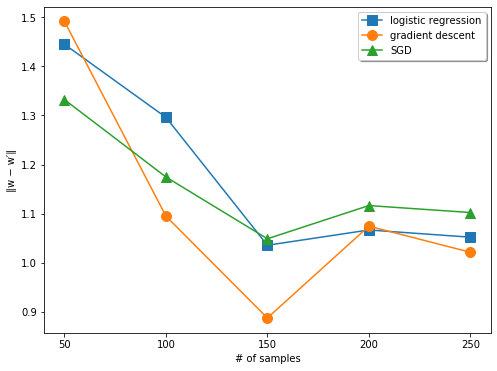

In [29]:
x_values = [i for i in range(1,6)]

fig = plt.figure(figsize=(8, 6))
plt.plot(x_values, logreg_ans, label='logistic regression', marker='s', markersize=10)
plt.plot(x_values, GD_ans, label='gradient descent', marker='o', markersize=10)
plt.plot(x_values, SGD_ans, label='SGD', marker='^', markersize=10)

labels = ['50', '100', '150', '200', '250']
plt.xticks(x_values, labels)

plt.xlabel('# of samples')
plt.ylabel('∥w − w′∥')
plt.legend(loc = 'upper right', 
                    shadow=True,
                    prop={'weight':'roman','size':'medium'})

plt.show()

In [30]:
T

[0.5768938064575195, 40.08903098106384, 6.202341079711914]

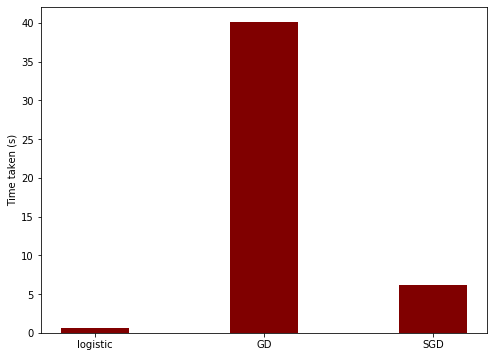

In [31]:
x_values = [i for i in range(1,4)]

fig = plt.figure(figsize=(8, 6))
plt.bar(x_values, T, color ='maroon', width = 0.4)

labels = ['logistic', 'GD', 'SGD']
plt.xticks(x_values, labels)

plt.ylabel('Time taken (s)')

plt.show()

# Problem 2

In [32]:
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import KFold

In [33]:
cancer = datasets.load_breast_cancer()

For each depth in $1, \dots, 5$, instantiate an AdaBoost classifier with the base learner set to be a decision tree of that depth (set `n_estimators=10` and `learning_rate=1`), and then record the 10-fold cross-validated error on the entire breast cancer data set. Plot the resulting curve of accuracy against base classifier depth. Use $101$ as your random state for both the base learner as well as the AdaBoost classifier every time.

In [34]:
X = cancer.data
y = cancer.target

In [35]:
accuracies_CV = []
kf = KFold(n_splits=10, random_state=101, shuffle=True)  # cross-validation, 10-fold

for j in range(1,6): # DecisionTree: depth from 1 to 5
    accuracies_j = []
    for train_index, test_index in kf.split(X):
        data_train   = X[train_index]
        target_train = y[train_index]  
        data_test    = X[test_index]
        target_test  = y[test_index]

        # Ada-boosting classifier, base learner of which is DecisionTree with different depth
        clf_Ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=j), 
                                     n_estimators=100, learning_rate=1, random_state=101) 
        clf_Ada.fit(data_train,target_train)
        preds = clf_Ada.predict(data_test)
        
        # accuracy of each fold    
        accuracy = accuracy_score(target_test, preds)
        accuracies_j.append(accuracy)

# average accuracy over all folds
    average_accuracy = round(np.mean(accuracies_j),4)
    accuracies_CV.append(average_accuracy)

print(accuracies_CV)

[0.9701, 0.9684, 0.9684, 0.9684, 0.9719]


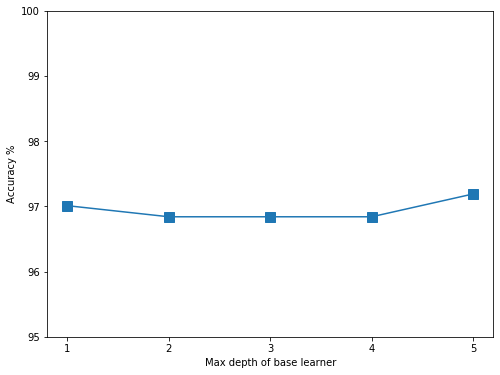

In [36]:
x_values = [i for i in range(1,6)]

fig = plt.figure(figsize=(8, 6))
plt.plot(x_values, np.dot(accuracies_CV, 100), marker='s', markersize=10)
plt.ylim(95, 100)
plt.xticks(x_values)

plt.xlabel('Max depth of base learner')
plt.ylabel('Accuracy %')

plt.show()